In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import xarray as xr
import cmocean.cm as cmocean
import glob
import matplotlib.path as mpath
import matplotlib.colors as col

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

figdir = '/g/data/v45/akm157/figures/basal_melt_param/'

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 6
Total threads: 24,Total memory: 128.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38195,Workers: 6
Dashboard: /proxy/8787/status,Total threads: 24
Started: Just now,Total memory: 128.00 GiB
Comm: tcp://127.0.0.1:44093,Total threads: 4
Dashboard: /proxy/40513/status,Memory: 21.33 GiB
Nanny: tcp://127.0.0.1:38199,


In [3]:
session_name = '/g/data/v45/wf4500/databases/gdata_01deg_jra55v13_ryf9091_DSW.db'
master_session = cc.database.create_session(session_name)
control = '01deg_jra55v13_ryf9091_DSW'

In [4]:
basal_gade_woa = 'accessom2-GPC023'

icb_gade_woa = 'accessom2-GPC026'

start_time='1900-01-01'
end_time='1901-01-01'

lat_slice  = slice(-80,-59)

In [5]:
# build database for these experiments:
session_name = '/g/data/e14/pc5520/model_data/access-om2/basal_melt_MOM5/basal_melt_MOM5.db'
basal_melt_session = cc.database.create_session(session_name)

dir_list = ['/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC023/accessom2-GPC023/',
           '/g/data/ik11/outputs/access-om2-01/basal_melt_outputs/accessom2-GPC026/accessom2-GPC026/']

#cc.database.build_index(dir_list,basal_melt_session)

In [6]:
# topography data for plotting:
ht = cc.querying.getvar(control,'ht' , master_session,n=1).sel(yt_ocean=lat_slice)
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)] = 1
land_mask = np.where(land_mask==1,land_mask,np.nan)
land_mask_masked = np.ma.masked_where((land_mask==0),land_mask)
# make land go all the way to -90S:
land_mask_lat = ht.yt_ocean.values
land_mask_lat[0] = -90

fontsize=15

In [7]:
start_time='1909-01-01'
end_time='1910-01-01'

temp_con = cc.querying.getvar(control, 'temp', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_con = temp_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_con = temp_con.mean('time').load()

temp_basal = cc.querying.getvar(basal_gade_woa, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_basal = temp_basal.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_basal = temp_basal.mean('time').load()

temp_icb = cc.querying.getvar(icb_gade_woa, 'temp', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time) - 273.15
temp_icb = temp_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
temp_icb = temp_icb.mean('time').load()

In [8]:
# select out bottom values:

depth_array = temp_con * 0 + temp_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_temp_con = temp_con.where(depth_array.st_ocean >= max_depth)
bottom_temp_con = bottom_temp_con.sum(dim = 'st_ocean')
bottom_temp_con = bottom_temp_con.load()

bottom_temp_basal = temp_basal.where(depth_array.st_ocean >= max_depth)
bottom_temp_basal = bottom_temp_basal.sum(dim = 'st_ocean')
bottom_temp_basal = bottom_temp_basal.load()

bottom_temp_icb = temp_icb.where(depth_array.st_ocean >= max_depth)
bottom_temp_icb = bottom_temp_icb.sum(dim = 'st_ocean')
bottom_temp_icb = bottom_temp_icb.load()

In [9]:
#Schmidtko

In [10]:
#Load obs data

In [11]:
# this is actually ASBW despite the naming:
filepath = '/g/data/v45/rm2389/Schmidtko_Observations/AASW_Temp_Salt.nc'
Schmidtko_data = xr.open_dataset(filepath)
temp_Schmidtko = Schmidtko_data.CT
salt_Schmidtko = Schmidtko_data.AS

# concat observations onto model grid.
x = temp_Schmidtko.lon.values
x[x> 80] = x[x>80]-360
# replace lon coordinate values with these modified longitude values
temp_Schmidtko['lon'] = x
salt_Schmidtko['lon'] = x
# now concatenate temp and salinity so that it goes from -280 to 80 like access
temp_Schmidtko = xr.concat((temp_Schmidtko[:,321:], temp_Schmidtko[:,:321]), dim='lon')
salt_Schmidtko = xr.concat((salt_Schmidtko[:,321:], salt_Schmidtko[:,:321]), dim='lon')

In [12]:
# interpolate obs onto model grid:

def interp_obs(obs,model_lat,model_lon): 
    obs_new = obs.interp(lat = model_lat, lon = model_lon)
    return obs_new

temp_Schmidtko = interp_obs(temp_Schmidtko,temp_con.yt_ocean,temp_con.xt_ocean)
salt_Schmidtko = interp_obs(salt_Schmidtko,temp_con.yt_ocean,temp_con.xt_ocean)

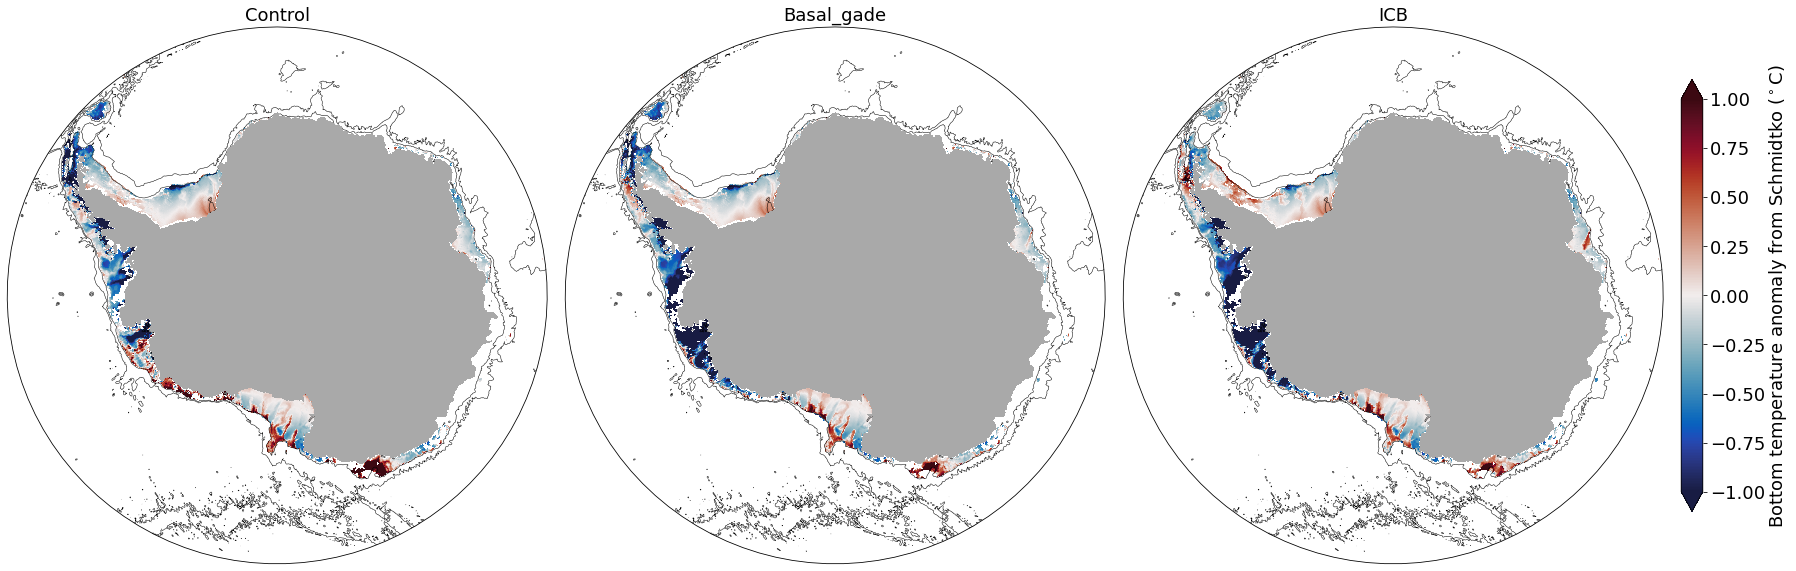

In [13]:
# compared to Schmidtko:

scale_max = 1
fontsize=18

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Control - Obs
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_con-temp_Schmidtko, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Basal - Obs
# setup stereo projection:
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_basal-temp_Schmidtko, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_gade',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# ICB - Obs
# setup stereo projection:
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_icb-temp_Schmidtko, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom temperature anomaly from Schmidtko ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)



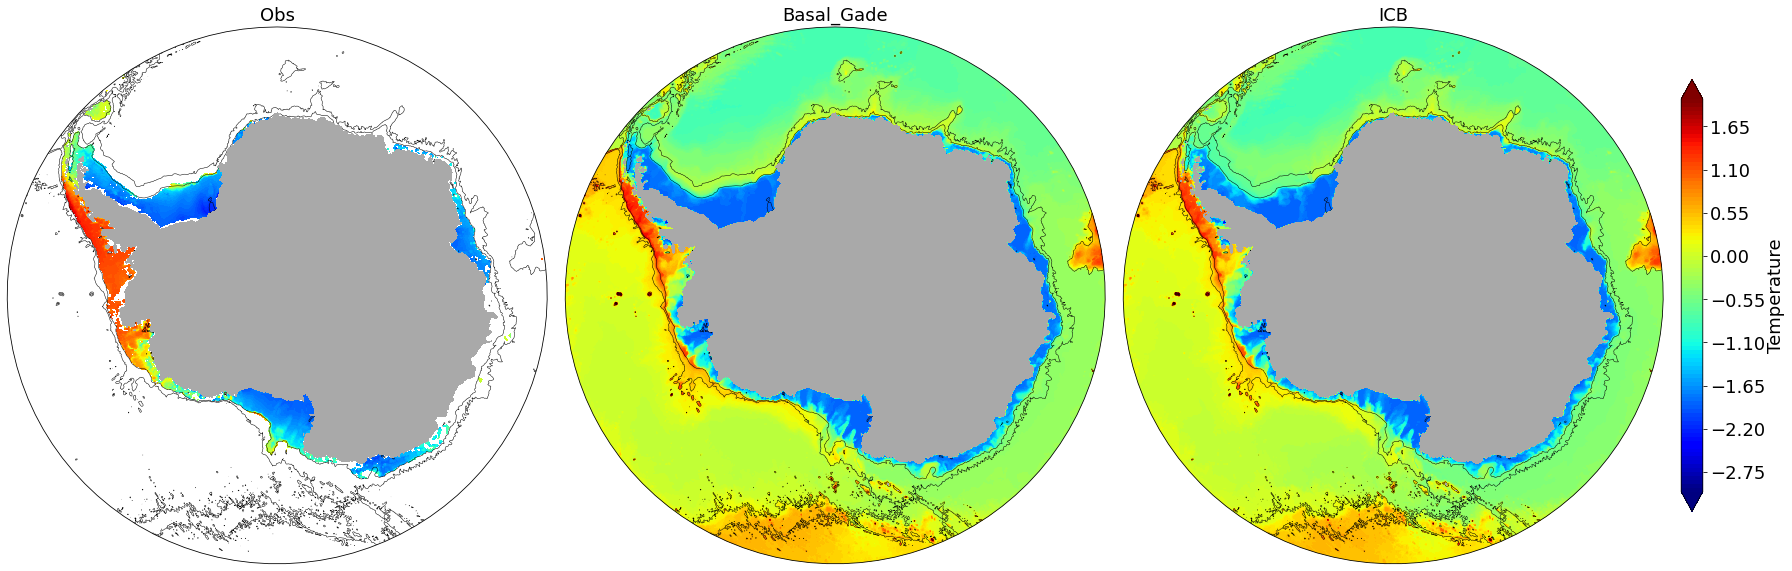

In [14]:
# compared to Schmidtko:

fontsize=18

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-3,vmax=2)
levels=np.arange(-3,2.005,.05)
ticks = [-3,-2,-1,0,1,2]

# Control - Obs
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.contourf(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, temp_Schmidtko, norm = norm, levels = levels,
                   cmap = cmocean.cm.jet, extend='both', transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Obs',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Basal - Obs
# setup stereo projection:
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.contourf(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_basal, norm = norm, levels = levels,
                   cmap = cmocean.cm.jet, extend='both', transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Gade',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# ICB - Obs
# setup stereo projection:
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.contourf(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_icb, norm = norm, levels = levels,
                   cmap = cmocean.cm.jet, extend='both',transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Temperature',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [15]:
start_time='1909-01-01'
end_time='1910-01-01'

salt_con = cc.querying.getvar(control, 'salt', master_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_con = salt_con.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_con = salt_con.mean('time').load()

salt_basal = cc.querying.getvar(basal_gade_woa, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_basal = salt_basal.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_basal = salt_basal.mean('time').load()

salt_icb = cc.querying.getvar(icb_gade_woa, 'salt', basal_melt_session, frequency='1 monthly',start_time=start_time, end_time=end_time)
salt_icb = salt_salt_icb = salt_icb.sel(time=slice(start_time,end_time)).sel(yt_ocean=lat_slice)
salt_icb = salt_icb.mean('time').load()

In [16]:
# select out bottom values:

depth_array = salt_con * 0 + salt_con.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)

bottom_salt_con = salt_con.where(depth_array.st_ocean >= max_depth)
bottom_salt_con = bottom_salt_con.sum(dim = 'st_ocean')
bottom_salt_con = bottom_salt_con.load()

bottom_salt_basal = salt_basal.where(depth_array.st_ocean >= max_depth)
bottom_salt_basal = bottom_salt_basal.sum(dim = 'st_ocean')
bottom_salt_basal = bottom_salt_basal.load()

bottom_salt_icb = salt_icb.where(depth_array.st_ocean >= max_depth)
bottom_salt_icb = bottom_salt_icb.sum(dim = 'st_ocean')
bottom_salt_icb = bottom_salt_icb.load()

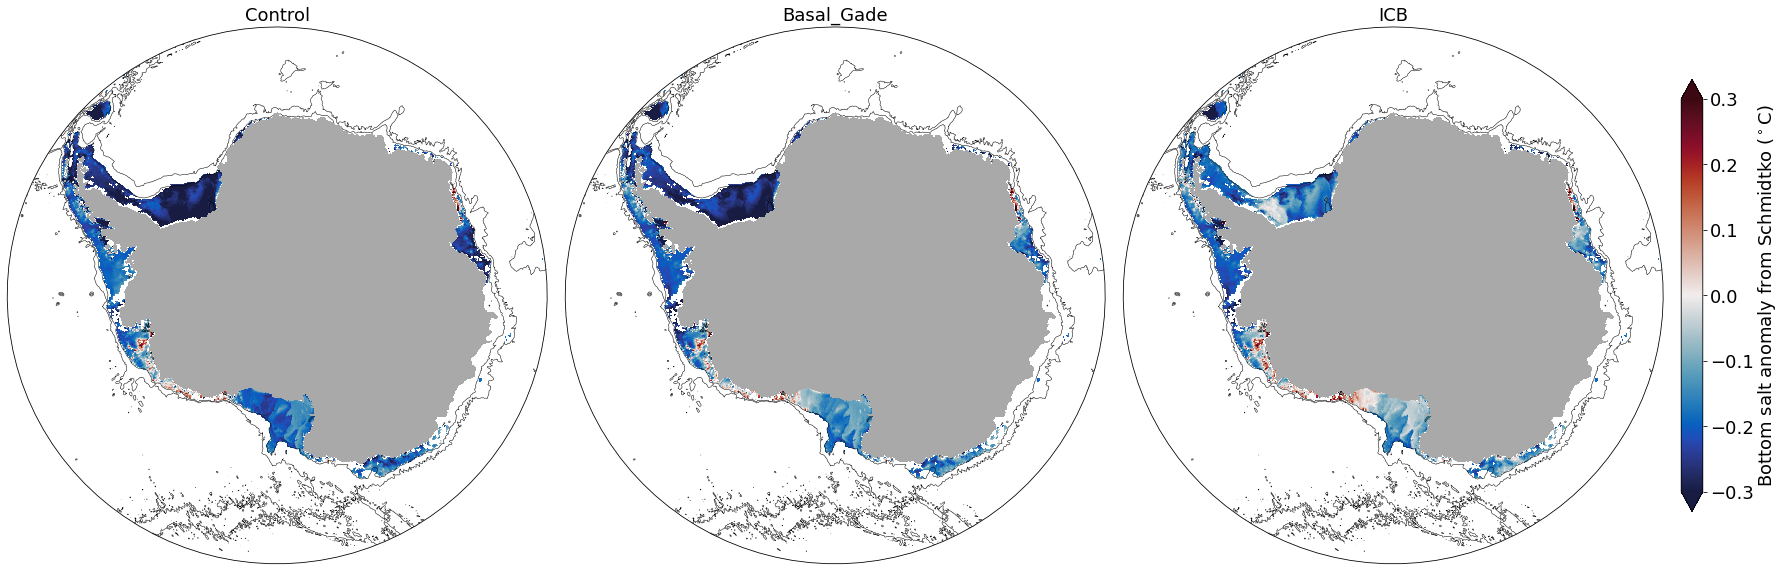

In [17]:
# compared to Schmidtko:

scale_max = 0.3
fontsize=18

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Control - Obs
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_con-salt_Schmidtko, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Control',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Basal - Obs
# setup stereo projection:
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_basal-salt_Schmidtko, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Gade',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# ICB - Obs
# setup stereo projection:
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_icb-salt_Schmidtko, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom salt anomaly from Schmidtko ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

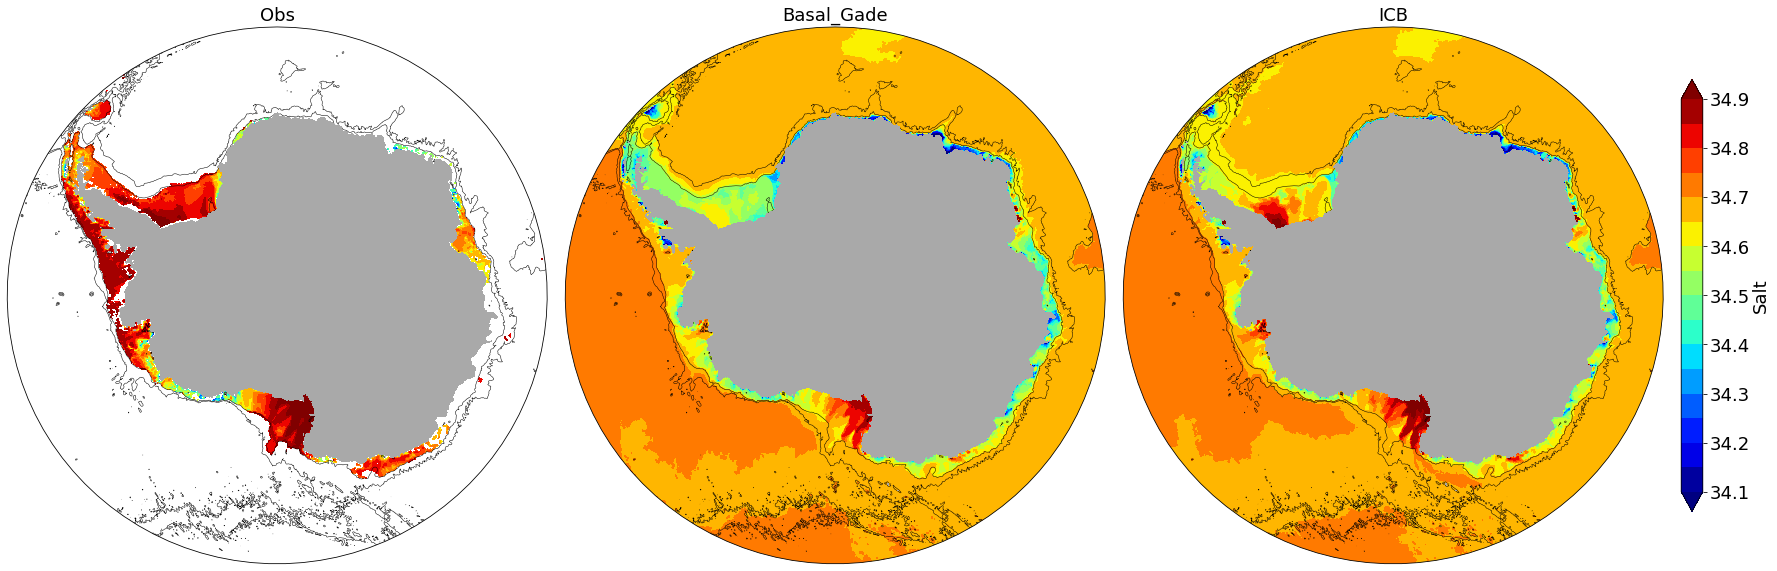

In [18]:
# compared to Schmidtko:

scale_max = 0.3
fontsize=18

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=34.1,vmax=34.9)
levels=np.arange(34.1,34.905,.05)
ticks = [34.3,34.4,34.5,34.6,34.7,34.8]

# Control - Obs
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.contourf(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, salt_Schmidtko, norm = norm, levels = levels,
                   cmap = cmocean.cm.jet, extend='both', transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Obs',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Basal - Obs
# setup stereo projection:
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.contourf(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_basal, norm = norm, levels = levels,
                   cmap = cmocean.cm.jet, extend='both', transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Basal_Gade',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# ICB - Obs
# setup stereo projection:
ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.contourf(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_icb, norm = norm, levels = levels,
                   cmap = cmocean.cm.jet, extend='both',transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('ICB',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Salt',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

In [18]:
#WOA

In [12]:
# this is actually ASBW despite the naming:
filepath_t = '/g/data/e14/pc5520/woa18_decav81B0_t00_04.nc'
filepath_s = '/g/data/e14/pc5520/woa18_decav81B0_s00_04.nc'

woa_data = xr.open_dataset(filepath_t,decode_times=False)
temp_woa = woa_data.t_an
woa_data = xr.open_dataset(filepath_s,decode_times=False)
salt_woa = woa_data.s_an

In [15]:
# concat observations onto model grid.
x = temp_woa.lon.values
x[x> 80] = -x[x>80]-100
# replace lon coordinate values with these modified longitude values
temp_woa['lon'] = x
salt_woa['lon'] = x
# now concatenate temp and salinity so that it goes from -280 to 80 like access
temp_woa = xr.concat((temp_woa[:,:,:,:401], temp_woa[:,:,:,401:]), dim='lon')
salt_woa = xr.concat((salt_woa[:,:,:,:401], salt_woa[:,:,:,401:]), dim='lon')

In [18]:
# interpolate obs onto model grid:

def interp_obs(obs,model_lat,model_lon): 
    obs_new = obs.interp(lat = model_lat, lon = model_lon)
    return obs_new

temp_woa_int = interp_obs(temp_woa,temp_con.yt_ocean,temp_con.xt_ocean)
salt_woa_int = interp_obs(salt_woa,temp_con.yt_ocean,temp_con.xt_ocean)

In [30]:
# select out bottom values:

depth_array = temp_woa_int * 0 + temp_woa_int.depth
max_depth = depth_array.max(dim = 'depth', skipna= True)

bottom_temp_woa = temp_woa_int.where(depth_array.depth >= max_depth)
bottom_temp_woa = bottom_temp_woa.sum(dim = 'depth')
bottom_temp_woa = bottom_temp_woa.load()

bottom_salt_woa = salt_woa_int.where(depth_array.depth >= max_depth)
bottom_salt_woa = bottom_salt_woa.sum(dim = 'depth')
bottom_salt_woa = bottom_salt_woa.load()

bottom_salt_woa = bottom_salt_woa[0,:,:]
bottom_temp_woa = bottom_temp_woa[0,:,:]

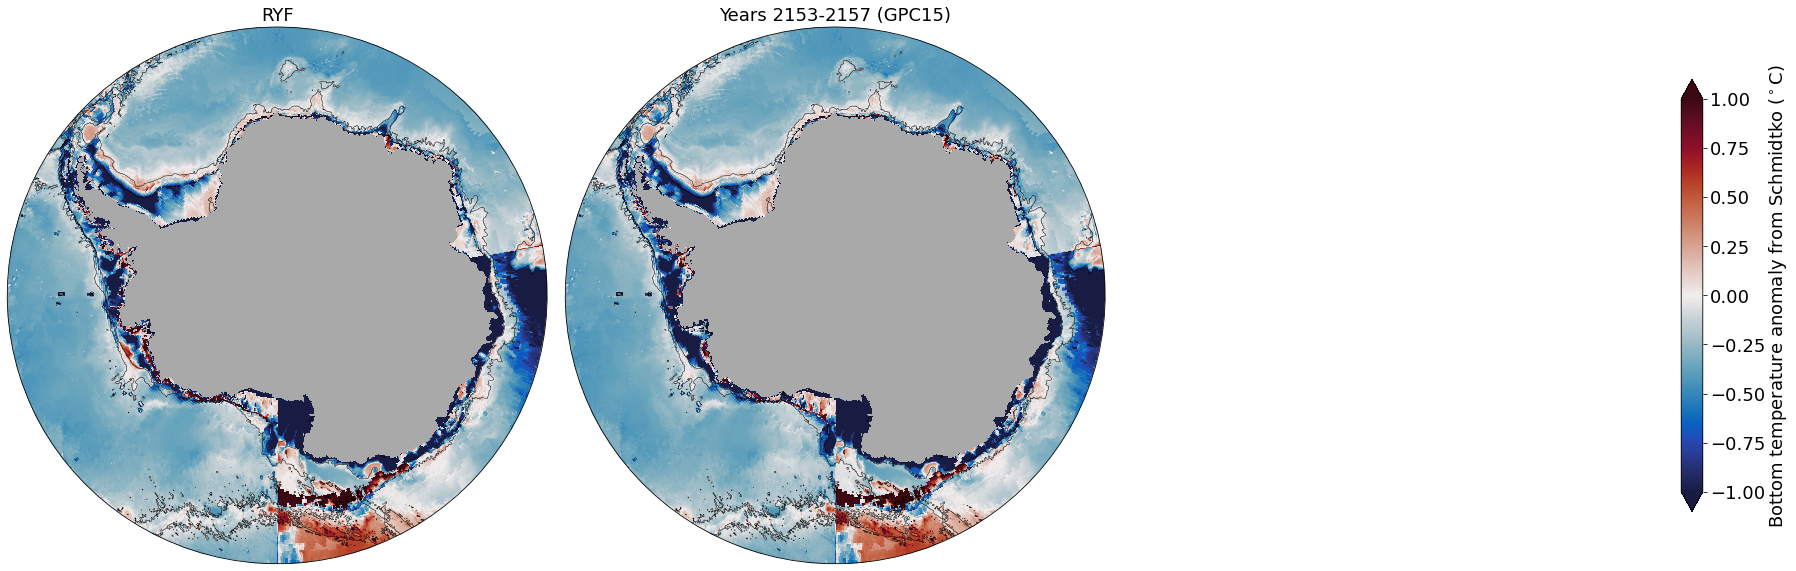

In [32]:
# compared to Schmidtko:

scale_max = 1
fontsize=18

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_con-bottom_temp_woa, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('RYF',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_insituS
# setup stereo projection:
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_basal-bottom_temp_woa, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Years 2153-2157 (GPC15)',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

## Tfreezing_zeroS
#ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(bottom_temp_con.xt_ocean, bottom_temp_con.yt_ocean, bottom_temp_basal_63_65-temp_Schmidtko, norm = norm, 
#                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Years 2163-2165 (GPC15)',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom temperature anomaly from Schmidtko ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)



In [ ]:
# compared to Schmidtko:

scale_max = 0.3
fontsize=18

fig  = plt.figure(1, figsize = (25,12))
norm = col.Normalize(vmin=-scale_max,vmax=scale_max)

# Tfreezing_insituS
# setup stereo projection:
ax = fig.add_axes([0.0, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_con-bottom_salt_Schmidtko, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('RYF',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# Tfreezing_insituS
# setup stereo projection:
ax = fig.add_axes([0.31, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
# plot:
cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_basal-salt_Schmidtko, norm = norm, 
                   cmap = cmocean.balance, transform = ccrs.PlateCarree())
ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
plt.title('Years 2153-2157 (GPC15)',fontsize=fontsize)
ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
             zorder=2,transform = ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

## Tfreezing_zeroS
#ax = fig.add_axes([0.62, 0.0, 0.3, 1],projection=ccrs.SouthPolarStereo())
#theta = np.linspace(0, 2*np.pi, 100)
#center, radius = [0.5, 0.5], 0.5
#verts = np.vstack([np.sin(theta), np.cos(theta)]).T
#circle = mpath.Path(verts * radius + center)
#ax.set_boundary(circle, transform=ax.transAxes)
## plot:
#cf = ax.pcolormesh(bottom_salt_con.xt_ocean, bottom_salt_con.yt_ocean, bottom_salt_basal_63_65-salt_Schmidtko, norm = norm, 
#                   cmap = cmocean.balance,transform = ccrs.PlateCarree())
#ax.contour(ht.xt_ocean,ht.yt_ocean,ht,levels=[1000,3000],colors='k',linewidths=0.5,transform = ccrs.PlateCarree())
#plt.title('Years 2163-2165 (GPC15)',fontsize=fontsize)
#ax.contourf(ht.xt_ocean, land_mask_lat,land_mask_masked,colors='darkgrey',
#             zorder=2,transform = ccrs.PlateCarree())
#ax.set_extent([-180, 180, -90, -59.5], ccrs.PlateCarree())

# colorbar:
cbaxes = fig.add_axes([0.93, 0.25, 0.012, 0.5])
cbar = plt.colorbar(cf, cax = cbaxes, orientation = 'vertical',extend = 'both')
cbar.set_label(r'Bottom salt anomaly from Schmidtko ($^\circ$C)',fontsize=fontsize,labelpad=2)
cbar.ax.tick_params(labelsize=fontsize)

